# Importing Librairies

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import plotly.express as px
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import pylab


# Loading dataset

In [2]:
# Load the data
df = pd.read_csv('../dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv', encoding='latin1')

## Visualisation des données manquantes ou null

In [4]:
import missingno as msno

df_numeric = df.select_dtypes(include=[np.number])

# Visualiser les valeurs manquantes
msno.matrix(df_numeric)
plt.show()

Ce dataset est vraiment propre, il ne contient pas de valeurs numériques manquantes ou null. mais on vas quand même aller plus loin et verifier s'il y a des Nan dans les colonnes de type object.

In [6]:
'''Cette ligne de code vérifie s'il y a des valeurs manquantes (NaN) dans chaque colonne du DataFrame'''

df.isnull().any()

ï»¿Age                      False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

# Visualisation du dataset et des informations sur les colonnes

In [7]:
df.head()

ï»¿Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [22]:
# renommer la colonne ï»¿Age en Age
df.rename(columns={'ï»¿Age': 'Age'}, inplace=True) 

In [8]:
# check the data types of the columns
df.dtypes

ï»¿Age                       int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

## Information principales sur le dataset

- le dataset contiens 1470 lignes et 35 colonnes.
- il n'y a pas de valeurs manquantes ou null dans le dataset ce qui facilite le travail.
- il y a 9 colonnes de type object et 26 colonnes de type numérique.
- la colonne target est 'Attrition' qui est de type object. Elle definit si un employé a quitté l'entreprise ou non. Le fameux Turnover.

On va maintenant visualiser les données pour mieux comprendre le dataset. Et essayer de faire hermeger une hypothèse sur les colonnes qui peuvent influencer le turnover.

### Repartition du turnover dans le dataset

In [20]:
# check the unbalanced data in the target column (Attrition)
df['Attrition'].value_counts()

# make graphs to show the distribution of the target column (Attrition)
fig = px.histogram(df, x='Attrition', title='Attrition Distribution')
#in percentage in an other graph with the percentage on each column print the percentage on eaxch bar

attrition_percentage = df['Attrition'].value_counts() / len(df) * 100
fig2 = px.bar(x=attrition_percentage.index, y=attrition_percentage.values, text=attrition_percentage.values, title='Attrition Percentage')

fig.show()
fig2.show()

On remarque qu'on a une repartition de 84% pour les employés qui n'ont pas quitté l'entreprise et 15% pour ceux qui ont quitté l'entreprise. Ce qui est un peu déséquilibré mais on va faire avec en le sachant pour faire no prediction future.

# Analyse de l'Impact de l'Âge, du Genre et du Salaire sur le Turnover

### Introduction

Le **turnover**, ou roulement de personnel, peut être influencé par plusieurs facteurs démographiques et économiques. Cette analyse propose d'estimer l'impact de l'âge, du genre et du salaire sur la probabilité de changer d'emploi. (les colonnes les plus interpretable pour le moment).

### Hypothèse Principale

Il est souvent supposé que **l'âge** joue un rôle crucial dans le turnover. Les jeunes employés, en début de carrière, sont généralement plus enclins à changer de poste. Cette période de la vie professionnelle est propice à l'exploration et offre de nombreuses opportunités pour l'évolution de carrière. De plus, changer fréquemment d'emploi peut être perçu comme un moyen d'obtenir des augmentations de salaire plus significatives et plus rapides. A contrario, les employés plus âgés, avec plus d'expérience, peuvent être plus stables et moins enclins à changer d'emploi.

### Analyse du Genre

Quant au **genre**, il n'est pas évident qu'il y ait une prédisposition claire affectant le turnover. Cependant, il est essentiel de vérifier cette hypothèse afin d'identifier toute tendance ou disparité potentielles.

### Objectifs de l'Analyse

Cette analyse vise à :
- Examiner l'influence de l'âge sur le turnover.
- Déterminer si le genre a un impact significatif sur les taux de turnover.
- Évaluer comment les variations de salaire influencent la décision de changer d'emploi.

## Analyse de l'Âge

In [31]:
# check de la distribution de l'age. on va faire un boxplot, un histogramme, un scatterplot et un violinplot

fig = px.box(df, x='Age', title='Age Distribution')
fig.show()

# boxplot avec plt de seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(df['Age'])
plt.title('Age Distribution')
plt.show()

fig = px.histogram(df, x='Age', title='Age Distribution')
fig.show()

# normal qqplot pour vérifier la normalité de la distribution de l'age
stats.probplot(df['Age'], dist="norm", plot=pylab)
pylab.show()

Ce dataset est vraiment remarquable car aucune valeur aberratnte n'est présente sur l'age. Il y a une excellente repartition. Cela facilite grandement le travail d'analyse et de modélisation. On na pas besoin de faire de traitement sur les données.

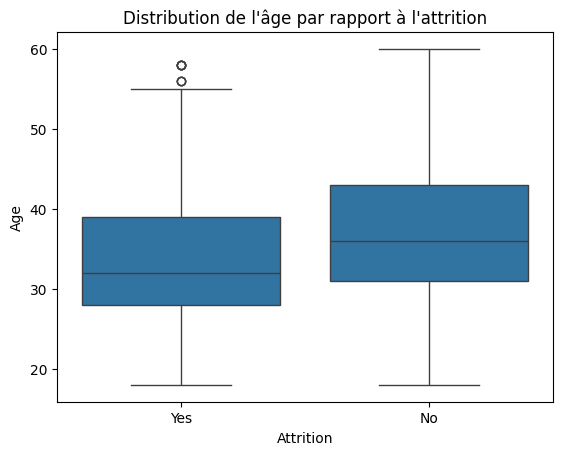

In [37]:
# visualisation de la distribution de l'age en fonction de l'attrition avec px line plot x =age y = count and two lines for attrition yes and no
ag_attrition = df.groupby(['Age', 'Attrition']).size().reset_index(name='Count')
fig = px.line(ag_attrition, x='Age', y='Count', color='Attrition', title='Age vs Attrition')
fig.show()

fig = px.violin(df, x='Attrition', y='Age', title='Age vs Attrition')
fig.show()

# Visualisation avec un boxplot
sns.boxplot(x='Attrition', y='Age', data=df)
plt.title('Distribution de l\'âge par rapport à l\'attrition')
plt.show()


### Test statistique

In [48]:

#test de normalité
stat, p = stats.shapiro(df['Age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# test de normalité avec D'Agostino and Pearson's test
stat, p = stats.normaltest(df['Age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# Séparer les âges en deux groupes selon l'attrition
ages_departed = df[df['Attrition'] == 'Yes']['Age']
ages_stayed = df[df['Attrition'] == 'No']['Age']

# Effectuer le test t de Welch
t_stat, p_value = ttest_ind(ages_departed, ages_stayed, equal_var=False)

print('T-statistic:', t_stat)
print('P-value:', p_value)

# test de Mann-Whitney U
u_statistic, p_value = mannwhitneyu(ages_departed, ages_stayed)

print('U-statistic:', u_statistic)
print('P-value:', p_value)


Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=54.684, p=0.000
Sample does not look Gaussian (reject H0)
T-statistic: -5.82801185398895
P-value: 1.3797600649439775e-08
U-statistic: 106859.0
P-value: 5.304342075341702e-11


### Interprétation des résultats

- **T-statistic** : -5.828
- **P-value** : 1.38*10^{-8}

1. Significativité statistique :
    - La p-value est inférieure à 0.05, ce qui est généralement le seuil accepté pour conclure à la significativité statistique. En fait, elle est même bien inférieure à 0.01, indiquant une forte significativité.
    - Cela signifie que vous pouvez rejeter l'hypothèse nulle qui postulait qu'il n'y a pas de différence significative dans l'âge moyen des employés qui quittent l'entreprise comparé à ceux qui y restent.

2. Valeur du T-statistic :
    - Le T-statistic négatif indique que le groupe des employés qui partent a un âge moyen inférieur à celui des employés qui restent. Cela confirme l'idée que les employés plus jeunes sont plus susceptibles de quitter l'entreprise.

### Analyse plus détaillée avec des tranches d'âge

- **Tranche d'Âge 1** : < 25 ans
- **Tranche d'Âge 2** : 25-35 ans
- **Tranche d'Âge 3** : 35-45 ans
- **Tranche d'Âge 4** : > 45 ans

## Analyse du salaire

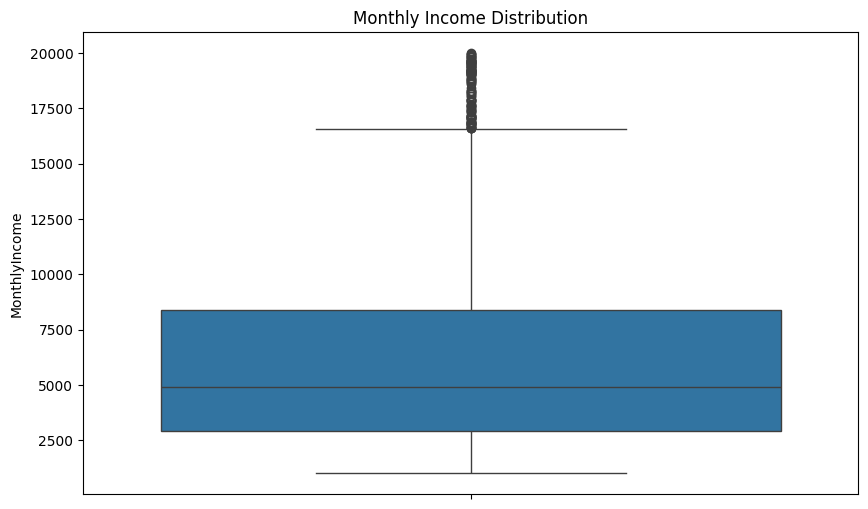

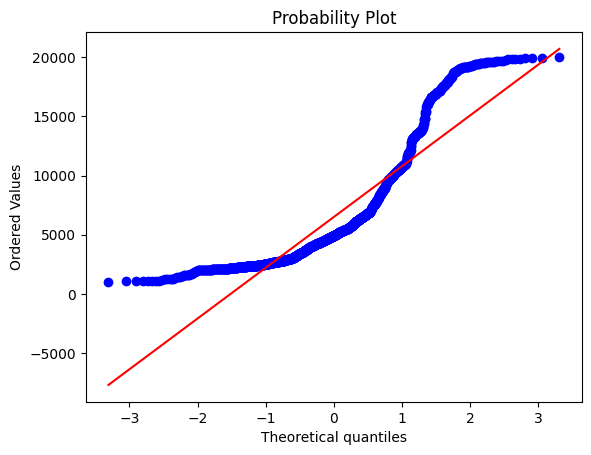

In [49]:
# check de la distribution du salaire mensuel. on va faire un boxplot, un histogramme, un scatterplot et un violinplot

fig = px.box(df, x='MonthlyIncome', title='Monthly Income Distribution')
fig.show()

# boxplot avec plt de seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(df['MonthlyIncome'])
plt.title('Monthly Income Distribution')
plt.show()

fig = px.histogram(df, x='MonthlyIncome', title='Monthly Income Distribution')
fig.show()

# normal qqplot pour vérifier la normalité de la distribution du salaire mensuel
stats.probplot(df['MonthlyIncome'], dist="norm", plot=pylab)
pylab.show()

#### Interprétation des résultats

ici les valeur sont moins facile a traité, il ya quand meme de gros ecarts entre les salaires, et on constate ainsi des valeurs abberantes. On va faire deux tests pour voir s'ils sont impactants pour les analyses.

### Test avec les valeurs abberantes

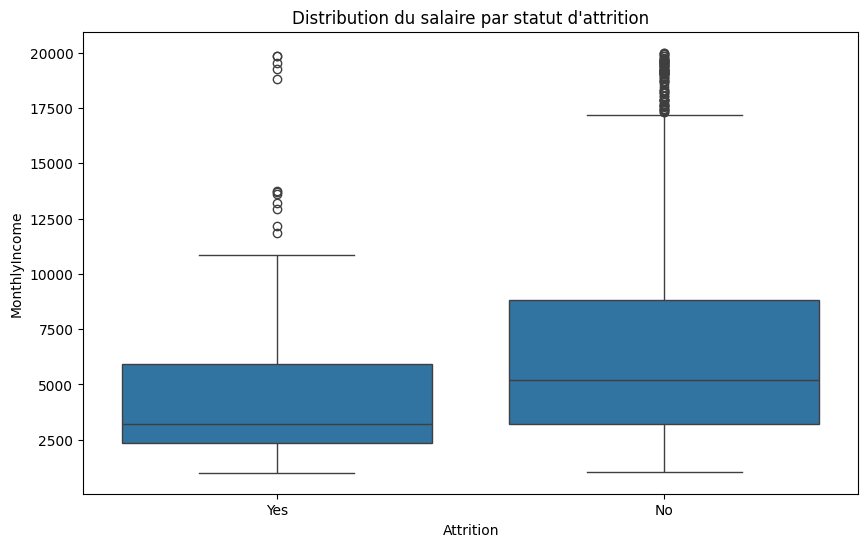

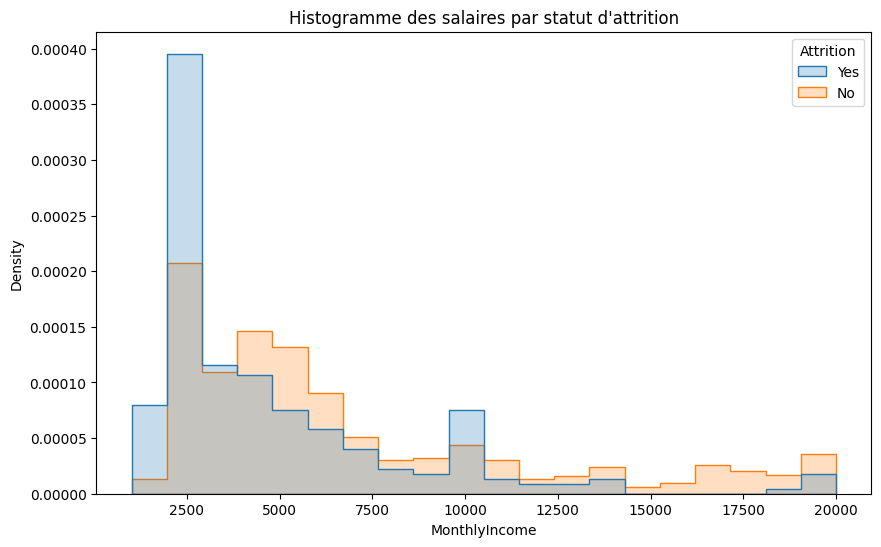

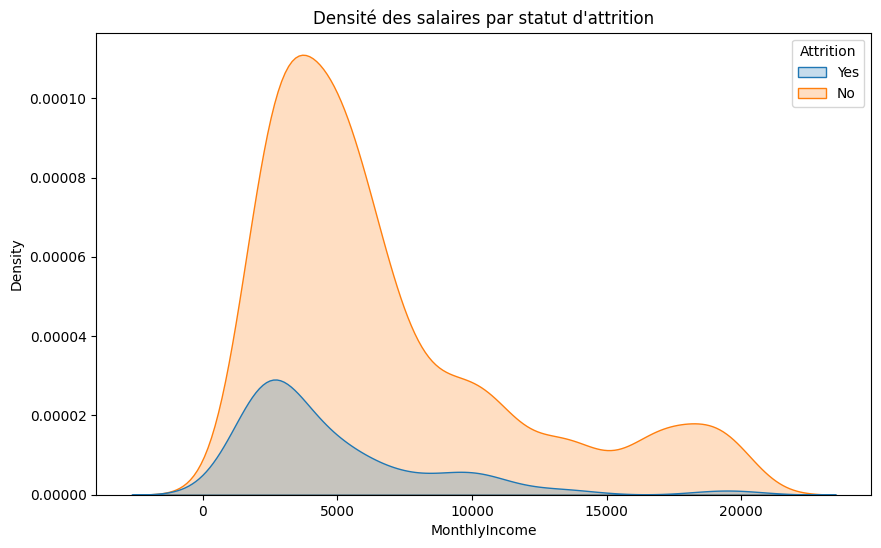

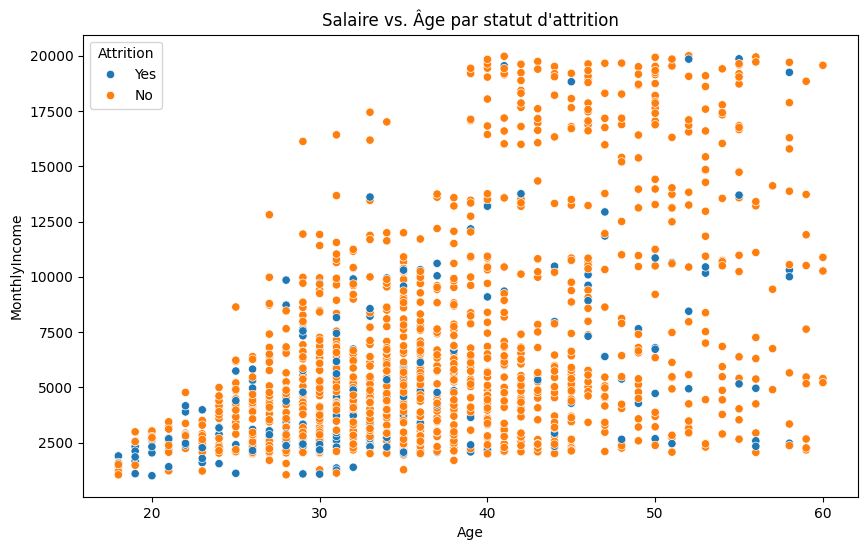

In [53]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Distribution du salaire par statut d\'attrition')
plt.show()

# Histogrammes superposés
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyIncome', hue='Attrition', element='step', stat='density', common_norm=False)
plt.title('Histogramme des salaires par statut d\'attrition')
plt.show()

# Diagrammes de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MonthlyIncome', hue='Attrition', fill=True)
plt.title('Densité des salaires par statut d\'attrition')
plt.show()

# Scatter plot (si vous avez une autre variable, par exemple 'Age')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MonthlyIncome', hue='Attrition')
plt.title('Salaire vs. Âge par statut d\'attrition')
plt.show()


fig = px.violin(df, x='Attrition', y='MonthlyIncome', title='Monthly Income vs Attrition')
fig.show()

#### Interprétation des résultats

D'après nos premières visualisations graphiques, une tendance semble se dessiner : les employés ayant un salaire inférieur sont plus enclins à quitter leur emploi. En revanche, ceux dont le salaire est élevé tendent à rester dans l'entreprise plus longtemps. Cette tendance se maintient jusqu'à un certain seuil, au-delà duquel les salaires très élevés ne semblent plus garantir la rétention des employés, indiquant la présence de valeurs aberrantes.

on va essayer de valider ca avec des tests statistiques.

### Test sans les valeurs abberantes

C:\Users\alexa\AppData\Local\Temp\ipykernel_26884\3443707221.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





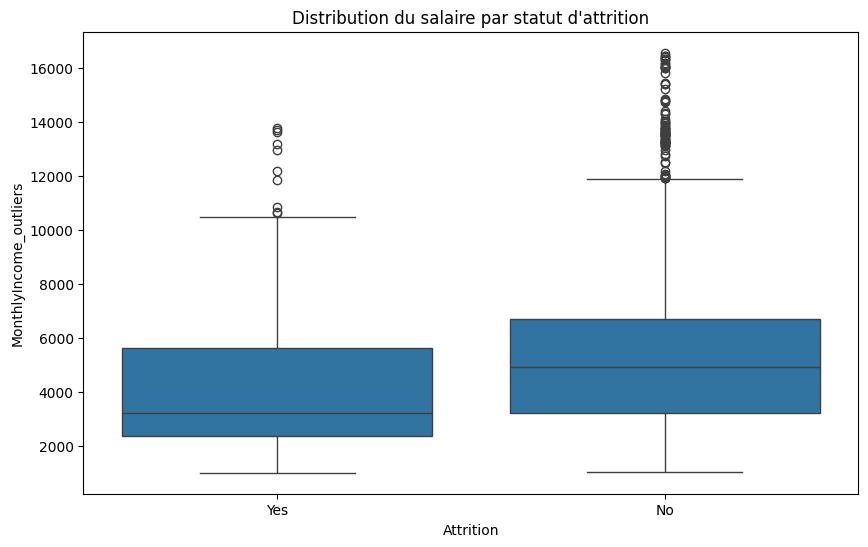

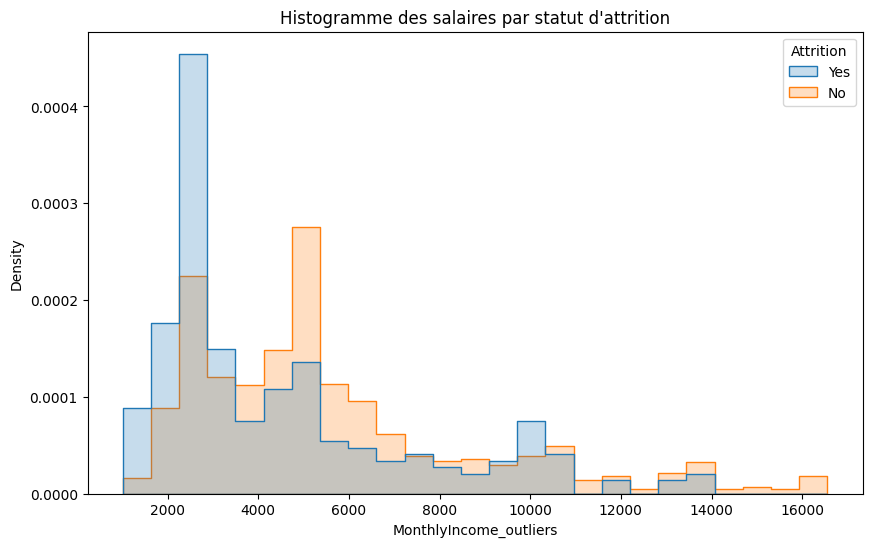

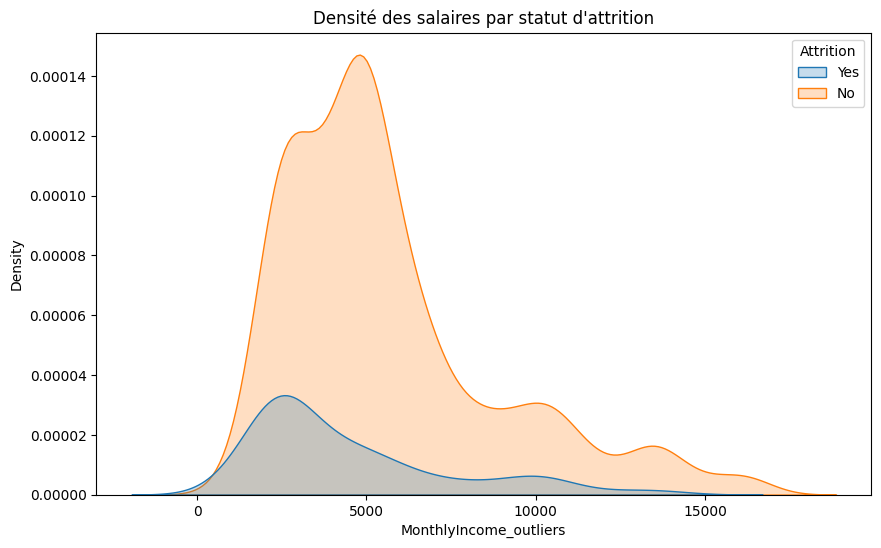

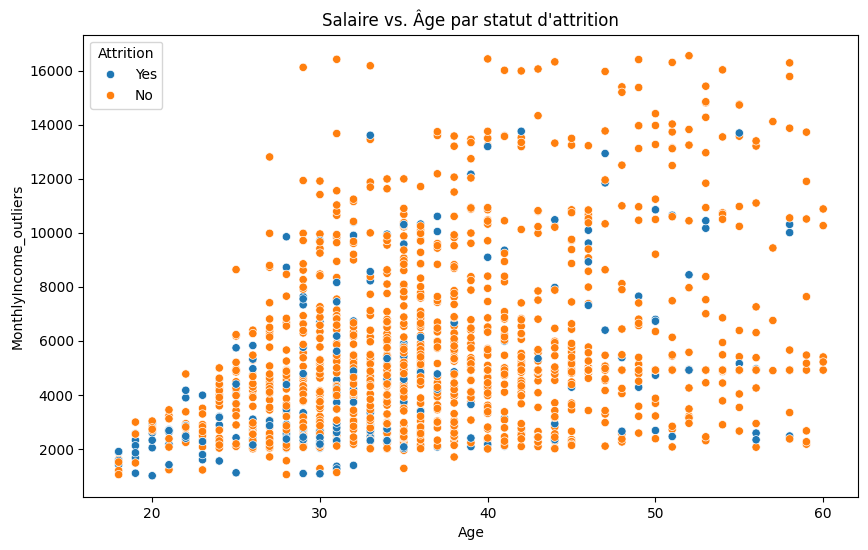

In [55]:
# suppression des valeurs aberrantes pour le salaire mensuel avec suppression des valeurs supérieures au troisième quartile + 1.5 * IQR
Q1 = df['MonthlyIncome'].quantile(0.25)
Q3 = df['MonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1
#ajout d'une colonne pour les valeurs non aberrantes
df['MonthlyIncome_outliers'] = df['MonthlyIncome']
df['MonthlyIncome_outliers'] = df['MonthlyIncome_outliers'].apply(lambda x: x if x >= (Q1 - 1.5 * IQR) and x <= (Q3 + 1.5 * IQR) else np.nan)

#remplacement des valeurs aberrantes par la médiane
median = df['MonthlyIncome'].median()
df['MonthlyIncome_outliers'].fillna(median, inplace=True)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome_outliers', data=df)
plt.title('Distribution du salaire par statut d\'attrition')
plt.show()

# Histogrammes superposés
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MonthlyIncome_outliers', hue='Attrition', element='step', stat='density', common_norm=False)
plt.title('Histogramme des salaires par statut d\'attrition')
plt.show()

# Diagrammes de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MonthlyIncome_outliers', hue='Attrition', fill=True)
plt.title('Densité des salaires par statut d\'attrition')
plt.show()

# Scatter plot (si vous avez une autre variable, par exemple 'Age')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='MonthlyIncome_outliers', hue='Attrition')
plt.title('Salaire vs. Âge par statut d\'attrition')
plt.show()

fig = px.violin(df, x='Attrition', y='MonthlyIncome_outliers', title='Monthly Income vs Attrition')
fig.show()

Il n'y a pas d'impact significatif des valeurs abberantes sur les analyses. On peut donc continuer sans les supprimer.

### Test statistique

In [57]:
#test de normalité pour le salaire mensuel
stat, p = stats.shapiro(df['MonthlyIncome_outliers'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# test de normalité avec D'Agostino and Pearson's test
stat, p = stats.normaltest(df['MonthlyIncome_outliers'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# Séparer les salaires mensuels en deux groupes selon l'attrition
salaries_departed = df[df['Attrition'] == 'Yes']['MonthlyIncome_outliers']
salaries_stayed = df[df['Attrition'] == 'No']['MonthlyIncome_outliers']

# Effectuer le test t de Welch
t_stat, p_value = ttest_ind(salaries_departed, salaries_stayed, equal_var=False)
print('T-statistic:', t_stat)
print('P-value:', p_value)

# test de Mann-Whitney U
u_statistic, p_value = mannwhitneyu(salaries_departed, salaries_stayed)
print('U-statistic:', u_statistic)
print('P-value:', p_value)

Statistics=0.877, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=290.613, p=0.000
Sample does not look Gaussian (reject H0)
T-statistic: -5.517657529431176
P-value: 6.652151238720782e-08
U-statistic: 105555.0
P-value: 1.22209674004531e-11
